In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
output_dir = Path('ex7_output')
dfs = []
for filename in output_dir.glob('*.csv'):
    df = pd.read_csv(str(filename))
    df['filename'] = filename.name
    dfs.append(df)
    # Read the CSV file and append to the list
domains = pd.concat(dfs, ignore_index=True)
domains.sort_values(by=['filename', 'domain'], inplace=True)
domains.reset_index(drop=True, inplace=True)
del dfs
n_domains = domains['exists'].sum()
print(f'Number of domains: {n_domains}')
domains[domains['exists']> 0]

Number of domains: 7


,domain,exists,filename
14179,eefd.ufrj.br,1,job_110.csv
64213,eba.ufrj.br,1,job_4.csv
68378,idt.ufrj.br,1,job_43.csv
68751,sga.ufrj.br,1,job_43.csv
71620,oec.ufrj.br,1,job_46.csv
97702,ppge.ufrj.br,1,job_7.csv
117443,injc.ufrj.br,1,job_88.csv


In [3]:
results = pd.DataFrame(columns=['n_samples', 'n_domains'])
results['n_samples'] = np.concatenate([np.logspace(0, 5, num=10, dtype=int), [len(domains)]])
results['n_domains'] = results['n_samples'].apply(
    lambda n: np.sum(np.random.choice(domains['exists'], n, replace=False))
)
results

,n_samples,n_domains
0,1,0
1,3,0
2,12,0
3,46,0
4,166,0
5,599,0
6,2154,1
7,7742,0
8,27825,3
9,100000,5


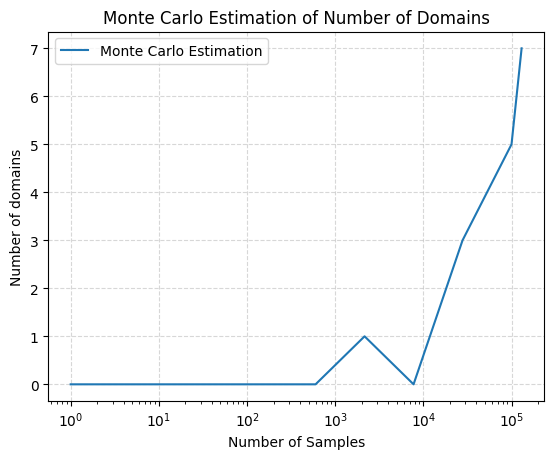

In [4]:
fig, ax = plt.subplots()
ax.grid(linestyle='--', alpha=0.5)
ax.plot(results['n_samples'].values, results['n_domains'].values, label='Monte Carlo Estimation')
# ax.axhline(n_domains, label=f'Real Value: {n_domains}', color='black', linestyle='--')
ax.set_xlabel('Number of Samples')
# ax.set_ylabel('Integral Estimate')
ax.set_ylabel('Number of domains')
ax.set_title('Monte Carlo Estimation of Number of Domains')
ax.legend()
ax.set_xscale('log')

fig.savefig(output_dir / 'ex7_plot.png', dpi=300)